In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from lib.RegDatasetLoader import RegDatasetLoader
from lib.RegFCNN import RegFCNN
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
device = 'cpu'

In [3]:
train_data = RegDatasetLoader(r'..\data\processed_winequality.csv', count=0.8, begin="head")
test_data = RegDatasetLoader(r'..\data\processed_winequality.csv', count=0.2, begin="tail")

train_data, val_data = random_split(train_data, [0.8, 0.2])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [4]:
fcnn = RegFCNN(13, 1).to(device)

loss_model = nn.MSELoss()
opt = torch.optim.Adam(fcnn.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=7,
                                                          threshold=1e-4,
                                                          threshold_mode='rel',
                                                          cooldown=3,
                                                          min_lr=0,
                                                          eps=1e-8,
                                                          )

In [5]:
EPOCHS = 5
train_loss, val_loss = [], []
train_mse, train_mae, train_rmse, train_mape, train_r2 = [], [], [], [], []
val_mse, val_mae, val_rmse, val_mape, val_r2 = [], [], [], [], []
list_ = []

for epoch in range(EPOCHS):
    fcnn.train()
    running_train_loss = []
    all_train_preds, all_train_targets = [], []
    train_loop = tqdm(train_loader, leave=False)

    for x, targets in train_loop:
        x = x.to(device)
        targets = targets.to(device)

        pred = fcnn(x).squeeze(-1) 
        loss = loss_model(pred, targets)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_train_loss.append(loss.item())
        all_train_preds.extend(pred.detach().cpu().numpy().flatten())
        all_train_targets.extend(targets.cpu().numpy().flatten())

        train_loop.set_description(
            f"Epoch {epoch + 1}/{EPOCHS}; loss={np.mean(running_train_loss):.4f}"
        )

    mean_train_loss = np.mean(running_train_loss)
    mse = mean_squared_error(np.array(all_train_targets), np.array(all_train_preds))
    mae = mean_absolute_error(np.array(all_train_targets), np.array(all_train_preds))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(all_train_targets) - np.array(all_train_preds)) / np.array(all_train_targets))) * 100  
    r2 = r2_score(np.array(all_train_targets), np.array(all_train_preds))

    train_loss.append(mean_train_loss)
    train_mse.append(mse)
    train_mae.append(mae)
    train_rmse.append(rmse)
    train_mape.append(mape)
    train_r2.append(r2)

    fcnn.eval()
    with torch.no_grad():
        running_val_loss = []
        all_val_preds, all_val_targets = [], []
        for x, targets in val_loader:
            x = x.to(device)
            targets = targets.to(device)

            pred = fcnn(x).squeeze(-1) 
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            all_val_preds.extend(pred.detach().cpu().numpy().flatten())
            all_val_targets.extend(targets.cpu().numpy().flatten())

        mean_val_loss = np.mean(running_val_loss)
        mse = mean_squared_error(np.array(all_val_targets), np.array(all_val_preds))
        mae = mean_absolute_error(np.array(all_val_targets), np.array(all_val_preds))
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((np.array(all_val_targets) - np.array(all_val_preds)) / np.array(all_val_targets))) * 100  
        r2 = r2_score(np.array(all_val_targets), np.array(all_val_preds))

        lr_scheduler.step(metrics=mean_val_loss)
        lr = lr_scheduler.get_last_lr()
        list_.append(lr)

        val_loss.append(mean_val_loss)
        val_mse.append(mse)
        val_mae.append(mae)
        val_rmse.append(rmse)
        val_mape.append(mape)
        val_r2.append(r2)

    print(
        f"Epoch {epoch+1}/{EPOCHS}; "
        f"train_loss={mean_train_loss:.4f}; MSE={train_mse[-1]:.4f}; MAE={train_mae[-1]:.4f}; RMSE={train_rmse[-1]:.4f}; MAPE={train_mape[-1]:.2f}%; R2={train_r2[-1]:.4f}; "
        f"val_loss={mean_val_loss:.4f}; MSE={val_mse[-1]:.4f}; MAE={val_mae[-1]:.4f}; RMSE={val_rmse[-1]:.4f}; MAPE={val_mape[-1]:.2f}%; R2={val_r2[-1]:.4f}"
    )

Epoch 1/5; train_loss=18.7803; MSE=18.7734; MAE=3.5016; RMSE=4.3328; MAPE=60.86%; R2=-22.1208; val_loss=8.8197; MSE=8.8689; MAE=2.8719; RMSE=2.9781; MAPE=49.23%; R2=-10.4121


Epoch 2/5; train_loss=17.7532; MSE=17.7557; MAE=3.2422; RMSE=4.2137; MAPE=56.16%; R2=-20.8675; val_loss=8.5610; MSE=8.6079; MAE=2.8352; RMSE=2.9339; MAPE=48.63%; R2=-10.0762


Epoch 3/5; train_loss=17.9648; MSE=17.9698; MAE=3.2794; RMSE=4.2391; MAPE=56.79%; R2=-21.1311; val_loss=8.2413; MSE=8.2884; MAE=2.7785; RMSE=2.8790; MAPE=47.57%; R2=-9.6652


Epoch 4/5; train_loss=17.4550; MSE=17.4405; MAE=3.1955; RMSE=4.1762; MAPE=55.55%; R2=-20.4792; val_loss=9.5947; MSE=9.6536; MAE=3.0147; RMSE=3.1070; MAPE=51.81%; R2=-11.4219


Epoch 5/5; train_loss=17.2454; MSE=17.2486; MAE=3.1580; RMSE=4.1531; MAPE=54.88%; R2=-20.2429; val_loss=8.0207; MSE=8.0687; MAE=2.7474; RMSE=2.8405; MAPE=47.19%; R2=-9.3825


In [8]:
fcnn.eval()
with torch.no_grad():
    running_test_loss = []
    all_test_preds, all_test_targets = [], []
    for x, targets in test_loader:
        x = x.to(device)
        targets = targets.to(device)

        pred = fcnn(x).squeeze(-1) 
        loss = loss_model(pred, targets)

        running_test_loss.append(loss.item())

        running_test_loss.append(loss.item())
        all_test_preds.extend(pred.detach().cpu().numpy().flatten())
        all_test_targets.extend(targets.cpu().numpy())

    mean_test_loss = np.mean(running_test_loss)
    mse = mean_squared_error(np.array(all_test_targets), np.array(all_test_preds))
    mae = mean_absolute_error(np.array(all_test_targets), np.array(all_test_preds))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(all_test_targets) - np.array(all_test_preds)) / np.array(all_test_targets))) * 100  
    r2 = r2_score(np.array(all_test_targets), np.array(all_test_preds))

print(
    f"test_loss={mean_test_loss:.4f}; "
    f"MSE={mse:.4f}; MAE={mae:.4f}; RMSE={rmse:.4f}; MAPE={mape:.2f}%; R2={r2:.4f}"
)

test_loss=12.8053; MSE=12.8094; MAE=3.5125; RMSE=3.5790; MAPE=59.43%; R2=-19.4232


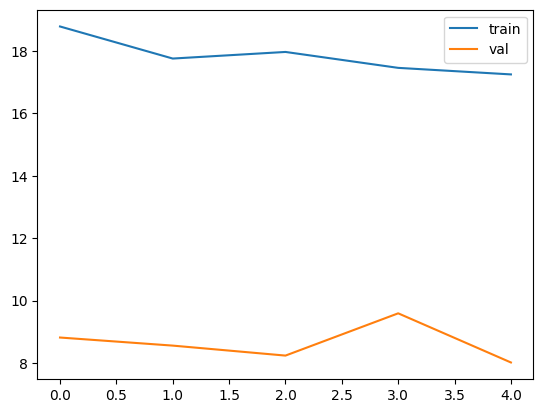

In [9]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.show()